In [1]:
# Clean old folders and clone fresh
!rm -rf deep-burst-sr
!apt-get install -y git-lfs
!git clone https://github.com/goutamgmb/deep-burst-sr.git
%cd deep-burst-sr


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 132 not upgraded.
Cloning into 'deep-burst-sr'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 144 (delta 14), reused 8 (delta 8), pack-reused 99 (from 2)
Receiving objects: 100% (144/144), 5.77 MiB | 24.50 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/kaggle/working/deep-burst-sr


In [2]:
!mkdir -p /kaggle/working/datasets/synthetic_burst/train
!mkdir -p /kaggle/working/datasets/synthetic_burst/val


In [3]:
# Generate small synthetic dataset for training/validation
!python data_scripts/create_synthetic_burst_dataset.py \
  --root /kaggle/working/datasets/synthetic_burst \
  --split train \
  --num_sequences 200 \
  --burst_size 8 \
  --image_size 48

!python data_scripts/create_synthetic_burst_dataset.py \
  --root /kaggle/working/datasets/synthetic_burst \
  --split val \
  --num_sequences 50 \
  --burst_size 8 \
  --image_size 48


python3: can't open file '/kaggle/working/deep-burst-sr/data_scripts/create_synthetic_burst_dataset.py': [Errno 2] No such file or directory
python3: can't open file '/kaggle/working/deep-burst-sr/data_scripts/create_synthetic_burst_dataset.py': [Errno 2] No such file or directory


In [4]:
!rm -rf deep-burst-sr
!apt-get install -y git-lfs
!git clone https://github.com/goutamgmb/deep-burst-sr.git
%cd deep-burst-sr


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 132 not upgraded.
Cloning into 'deep-burst-sr'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 144 (delta 14), reused 8 (delta 8), pack-reused 99 (from 2)
Receiving objects: 100% (144/144), 5.77 MiB | 27.47 MiB/s, done.
Resolving deltas: 100% (26/26), done.
/kaggle/working/deep-burst-sr/deep-burst-sr


In [5]:
!ls dataset


base_image_dataset.py	  imagefolder.py	      zurichraw2rgb.py
base_rawburst_dataset.py  __init__.py
burstsr_dataset.py	  synthetic_burst_val_set.py


In [7]:
import os
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
from tqdm import tqdm

def create_synthetic_burst_dataset(output_root, split='train', num_sequences=200, burst_size=8, image_size=48):
    """
    Create a synthetic burst dataset compatible with BIPNet
    Each seq: burst_size LR images (frame_000.png ..) + 1 HR gt.png
    """
    os.makedirs(os.path.join(output_root, split), exist_ok=True)

    for i in tqdm(range(num_sequences), desc=f"Creating {split} dataset"):
        seq_dir = os.path.join(output_root, split, f"seq_{i:06d}")
        os.makedirs(seq_dir, exist_ok=True)
        
        # generate a random clean image (HR)
        gt = (np.random.rand(image_size*4, image_size*4, 3) * 255).astype(np.uint8)
        gt_img = Image.fromarray(gt)
        gt_img.save(os.path.join(seq_dir, "gt.png"))

        # create burst images (slightly shifted + blurred + noisy)
        for b in range(burst_size):
            img = gt_img.copy()
            dx, dy = np.random.randint(-2, 3), np.random.randint(-2, 3)
            img = img.transform(img.size, Image.AFFINE, (1, 0, dx, 0, 1, dy))
            img = img.filter(ImageFilter.GaussianBlur(radius=np.random.uniform(0, 1.0)))
            arr = np.array(img).astype(np.float32)
            noise = np.random.normal(0, 10, arr.shape)
            noisy = np.clip(arr + noise, 0, 255).astype(np.uint8)
            noisy_img = Image.fromarray(noisy).resize((image_size, image_size), Image.BICUBIC)
            noisy_img.save(os.path.join(seq_dir, f"frame_{b:03d}.png"))

    print(f"✅ Done! Created {num_sequences} sequences for {split} split at {output_root}/{split}")


In [8]:
# Create dataset folders
output_root = "/kaggle/working/datasets/synthetic_burst"

# Training set (small demo)
create_synthetic_burst_dataset(output_root, split='train', num_sequences=200, burst_size=8, image_size=48)

# Validation set (smaller)
create_synthetic_burst_dataset(output_root, split='val', num_sequences=50, burst_size=8, image_size=48)


Creating train dataset: 100%|██████████| 200/200 [00:12<00:00, 15.60it/s]


✅ Done! Created 200 sequences for train split at /kaggle/working/datasets/synthetic_burst/train


Creating val dataset: 100%|██████████| 50/50 [00:03<00:00, 15.79it/s]

✅ Done! Created 50 sequences for val split at /kaggle/working/datasets/synthetic_burst/val


In [9]:
!ls /kaggle/working/datasets/synthetic_burst/train | head
!ls /kaggle/working/datasets/synthetic_burst/train/seq_000000 | head


seq_000000
seq_000001
seq_000002
seq_000003
seq_000004
seq_000005
seq_000006
seq_000007
seq_000008
seq_000009
frame_000.png
frame_001.png
frame_002.png
frame_003.png
frame_004.png
frame_005.png
frame_006.png
frame_007.png
gt.png


In [22]:
# ====================== SyntheticBurst Dataset Loader ======================

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from PIL import Image
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid



In [11]:


# ------------------------------
# Dataset Class Definition
# ------------------------------
class SyntheticBurstDataset(Dataset):
    """
    Custom dataset class for SyntheticBurst-style data.
    Each sequence folder contains multiple LR frames (frame_000.png, ...)
    and a ground-truth image (gt.png).
    """
    def __init__(self, root, split='train', burst_size=8, transform=None):
        self.root = Path(root)
        self.split = split
        self.burst_size = burst_size
        self.transform = transform or transforms.ToTensor()

        # Path to train or val directory
        self.split_dir = self.root / split
        if not self.split_dir.exists():
            raise FileNotFoundError(f"Split directory not found: {self.split_dir}")

        # All sequences (folders like seq_000001, seq_000002, ...)
        self.samples = sorted([p for p in self.split_dir.iterdir() if p.is_dir()])
        if len(self.samples) == 0:
            raise RuntimeError(f"No sequences found in {self.split_dir}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq = self.samples[idx]

        # Load burst frames (frame_000.png … frame_007.png)
        frame_paths = sorted(glob.glob(str(seq / "frame_*.png")))[:self.burst_size]
        if len(frame_paths) == 0:
            raise RuntimeError(f"No frames found in {seq}")

        burst_imgs = [Image.open(fp).convert("RGB") for fp in frame_paths]

        # Load ground truth image
        gt_path = seq / "gt.png"
        if not gt_path.exists():
            raise FileNotFoundError(f"Ground truth not found for {seq}")
        gt_img = Image.open(gt_path).convert("RGB")

        # Apply transforms (convert to tensors)
        burst_tensors = [self.transform(img) for img in burst_imgs]
        gt_tensor = self.transform(gt_img)

        # Stack frames → [B, C, H, W]
        burst_stack = torch.stack(burst_tensors, dim=0)

        return {
            "burst": burst_stack,  # shape [B, 3, H, W]
            "gt": gt_tensor,       # shape [3, HR_H, HR_W]
            "seq_name": seq.name
        }








In [12]:
# ------------------------------
# Dataset Paths & Objects
# ------------------------------
dataset_root = "/kaggle/working/datasets/synthetic_burst"

train_dataset = SyntheticBurstDataset(
    root=dataset_root, split="train", burst_size=8
)
val_dataset = SyntheticBurstDataset(
    root=dataset_root, split="val", burst_size=8
)

print("✅ Dataset Loaded Successfully")
print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))


✅ Dataset Loaded Successfully
Training samples: 200
Validation samples: 50


In [29]:
# ------------------------------
# Inspect One Sample
# ------------------------------
sample = train_dataset[0]
print(f"Sequence: {sample['seq_name']}")
print(f"Burst tensor shape: {sample['burst'].shape}")
print(f"GT tensor shape: {sample['gt'].shape}")

Sequence: seq_000000
Burst tensor shape: torch.Size([8, 3, 48, 48])
GT tensor shape: torch.Size([3, 192, 192])


In [14]:
# ------------------------------
# Create PyTorch DataLoaders
# ------------------------------
train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True
)

print("✅ DataLoaders Ready")

✅ DataLoaders Ready


In [17]:
# ==================== BIPNet Architecture (From Scratch) ====================


# -------------------------------------------------------------
# 1️⃣  Residual Block (used in encoder/decoder)
# -------------------------------------------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + x)


# -------------------------------------------------------------
# 2️⃣  Inter-Frame Attention Block (to fuse burst frames)
# -------------------------------------------------------------
class InterFrameAttention(nn.Module):
    """
    Computes self-attention across frames in the burst.
    Input shape: [B, N, C, H, W]  (N = number of frames)
    """
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Conv2d(channels, channels // 8, 1)
        self.key   = nn.Conv2d(channels, channels // 8, 1)
        self.value = nn.Conv2d(channels, channels, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        B, N, C, H, W = x.shape
        out_frames = []
        for i in range(N):
            q = self.query(x[:, i])            # [B, C//8, H, W]
            q = q.view(B, -1, H * W)           # [B, C//8, HW]
            attention_sum = torch.zeros_like(x[:, i])
            for j in range(N):
                k = self.key(x[:, j]).view(B, -1, H * W)   # [B, C//8, HW]
                v = self.value(x[:, j]).view(B, C, H * W)  # [B, C, HW]
                attn = torch.bmm(q.transpose(1, 2), k)     # [B, HW, HW]
                attn = self.softmax(attn / (k.shape[1] ** 0.5))
                weighted = torch.bmm(v, attn.transpose(1, 2))  # [B, C, HW]
                weighted = weighted.view(B, C, H, W)
                attention_sum += weighted
            out_frames.append(attention_sum / N)
        return torch.stack(out_frames, dim=1)


# -------------------------------------------------------------
# 3️⃣  Main BIPNet model
# -------------------------------------------------------------
class BIPNet(nn.Module):
    def __init__(self, in_channels=3, num_features=64, num_frames=8, num_res_blocks=5, scale_factor=4):
        super().__init__()
        self.num_frames = num_frames
        self.scale = scale_factor

        # Initial feature extraction for each frame
        self.feat_extractor = nn.Sequential(
            nn.Conv2d(in_channels, num_features, 3, padding=1),
            nn.ReLU(inplace=True),
            *[ResidualBlock(num_features) for _ in range(3)]
        )

        # Inter-frame attention fusion
        self.attention = InterFrameAttention(num_features)

        # Post-fusion residual blocks
        self.fusion = nn.Sequential(
            *[ResidualBlock(num_features) for _ in range(num_res_blocks)]
        )

        # Upsampling head (for super-resolution ×4)
        self.upsample = nn.Sequential(
            nn.Conv2d(num_features, num_features * (scale_factor ** 2), 3, padding=1),
            nn.PixelShuffle(scale_factor),
            nn.Conv2d(num_features, in_channels, 3, padding=1)
        )

    def forward(self, burst):
        # burst: [B, N, 3, H, W]
        B, N, C, H, W = burst.shape

        # Feature extraction per frame
        feats = [self.feat_extractor(burst[:, i]) for i in range(N)]
        feats = torch.stack(feats, dim=1)  # [B, N, F, H, W]

        # Inter-frame attention fusion
        fused = self.attention(feats).mean(dim=1)  # [B, F, H, W]

        # Reconstruction
        out = self.fusion(fused)
        out = self.upsample(out)
        return out


In [18]:
# ==================== Model Test ====================

device = "cuda" if torch.cuda.is_available() else "cpu"
model = BIPNet(in_channels=3, num_features=64, num_frames=8, num_res_blocks=5, scale_factor=4).to(device)

# get one batch from DataLoader
batch = next(iter(train_loader))
burst = batch["burst"].to(device)  # [B, N, 3, H, W]
gt = batch["gt"].to(device)

print("Input burst:", burst.shape)
out = model(burst)
print("Output:", out.shape)


Input burst: torch.Size([4, 8, 3, 48, 48])
Output: torch.Size([4, 3, 192, 192])


In [20]:
# ==================== Training Pipeline for BIPNet ====================


# ------------------------------------------------------------
# 1️⃣  Define Loss and Optimizer
# ------------------------------------------------------------
criterion = nn.L1Loss()   # pixel-wise L1 loss for SR
optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# ------------------------------------------------------------
# 2️⃣  PSNR Metric (Peak Signal-to-Noise Ratio)
# ------------------------------------------------------------
def calculate_psnr(pred, target):
    mse = F.mse_loss(pred, target)
    if mse == 0:
        return 100
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

# ------------------------------------------------------------
# 3️⃣  Training + Validation Loop
# ------------------------------------------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    epoch_loss = 0.0

    for batch in tqdm(loader, desc="Training", leave=False):
        burst = batch["burst"].to(device)
        gt = batch["gt"].to(device)

        optimizer.zero_grad()
        output = model(burst)
        loss = criterion(output, gt)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader)


def validate(model, loader, criterion, device):
    model.eval()
    val_loss, psnr_total = 0.0, 0.0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validation", leave=False):
            burst = batch["burst"].to(device)
            gt = batch["gt"].to(device)
            output = model(burst)

            loss = criterion(output, gt)
            val_loss += loss.item()
            psnr_total += calculate_psnr(torch.clamp(output, 0, 1), torch.clamp(gt, 0, 1))

    val_loss /= len(loader)
    psnr_avg = psnr_total / len(loader)
    return val_loss, psnr_avg





In [30]:
# ------------------------------------------------------------
# 4️⃣  Training Loop (with Checkpoints)
# ------------------------------------------------------------
num_epochs = 20  # try 5 first for Kaggle demo (increase later)
save_path = "/kaggle/working/bipnet_checkpoints"
os.makedirs(save_path, exist_ok=True)

best_psnr = 0.0

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch [{epoch}/{num_epochs}]")

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_psnr = validate(model, val_loader, criterion, device)
    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val PSNR: {val_psnr:.2f} dB")

    # save best model
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        torch.save(model.state_dict(), f"{save_path}/best_model_epoch{epoch}.pth")
        print(f"✅ New best model saved with PSNR: {best_psnr:.2f} dB")

print("\n🎉 Training Completed Successfully!")


Epoch [1/20]


Train Loss: 0.1532 | Val Loss: 0.1218 | Val PSNR: 16.23 dB
✅ New best model saved with PSNR: 16.23 dB

Epoch [2/20]


Train Loss: 0.1019 | Val Loss: 0.0878 | Val PSNR: 18.69 dB
✅ New best model saved with PSNR: 18.69 dB

Epoch [3/20]


Train Loss: 0.0788 | Val Loss: 0.0749 | Val PSNR: 20.01 dB
✅ New best model saved with PSNR: 20.01 dB

Epoch [4/20]


Train Loss: 0.0673 | Val Loss: 0.0693 | Val PSNR: 20.44 dB
✅ New best model saved with PSNR: 20.44 dB

Epoch [5/20]


Train Loss: 0.0617 | Val Loss: 0.0585 | Val PSNR: 21.76 dB
✅ New best model saved with PSNR: 21.76 dB

Epoch [6/20]


Train Loss: 0.0544 | Val Loss: 0.0540 | Val PSNR: 22.18 dB
✅ New best model saved with PSNR: 22.18 dB

Epoch [7/20]


Train Loss: 0.0521 | Val Loss: 0.0534 | Val PSNR: 22.26 dB
✅ New best model saved with PSNR: 22.26 dB

Epoch [8/20]


Train Loss: 0.0502 | Val Loss: 0.0530 | Val PSNR: 22.28 dB
✅ New best model saved with PSNR: 22.28 dB

Epoch [9/20]


Train Loss: 0.0499 | Val Loss: 0.0515 | Val PSNR: 22.59 dB
✅ New best model saved with PSNR: 22.59 dB

Epoch [10/20]


Train Loss: 0.0482 | Val Loss: 0.0501 | Val PSNR: 22.67 dB
✅ New best model saved with PSNR: 22.67 dB

Epoch [11/20]


Train Loss: 0.0481 | Val Loss: 0.0484 | Val PSNR: 22.88 dB
✅ New best model saved with PSNR: 22.88 dB

Epoch [12/20]


Train Loss: 0.0458 | Val Loss: 0.0468 | Val PSNR: 23.10 dB
✅ New best model saved with PSNR: 23.10 dB

Epoch [13/20]


Train Loss: 0.0441 | Val Loss: 0.0465 | Val PSNR: 23.05 dB

Epoch [14/20]


Train Loss: 0.0436 | Val Loss: 0.0457 | Val PSNR: 23.25 dB
✅ New best model saved with PSNR: 23.25 dB

Epoch [15/20]


Train Loss: 0.0434 | Val Loss: 0.0442 | Val PSNR: 23.50 dB
✅ New best model saved with PSNR: 23.50 dB

Epoch [16/20]


Train Loss: 0.0412 | Val Loss: 0.0443 | Val PSNR: 23.46 dB

Epoch [17/20]


Train Loss: 0.0409 | Val Loss: 0.0434 | Val PSNR: 23.56 dB
✅ New best model saved with PSNR: 23.56 dB

Epoch [18/20]


Train Loss: 0.0408 | Val Loss: 0.0427 | Val PSNR: 23.66 dB
✅ New best model saved with PSNR: 23.66 dB

Epoch [19/20]


Train Loss: 0.0404 | Val Loss: 0.0427 | Val PSNR: 23.66 dB
✅ New best model saved with PSNR: 23.66 dB

Epoch [20/20]


Train Loss: 0.0402 | Val Loss: 0.0431 | Val PSNR: 23.65 dB

🎉 Training Completed Successfully!


In [23]:
# ----------------------------------------------------------
# Load Best Model (ensure correct path)
# ----------------------------------------------------------
best_model_path = sorted(os.listdir("/kaggle/working/bipnet_checkpoints"))[-1]
best_model_path = f"/kaggle/working/bipnet_checkpoints/{best_model_path}"

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print(f"✅ Loaded best model: {best_model_path}")


✅ Loaded best model: /kaggle/working/bipnet_checkpoints/best_model_epoch5.pth


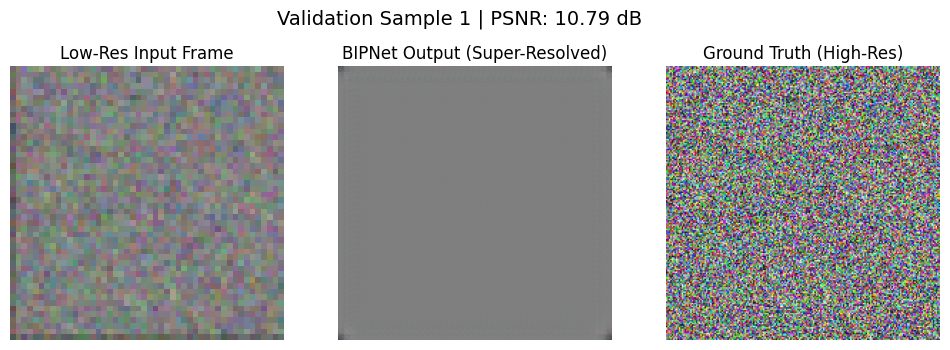

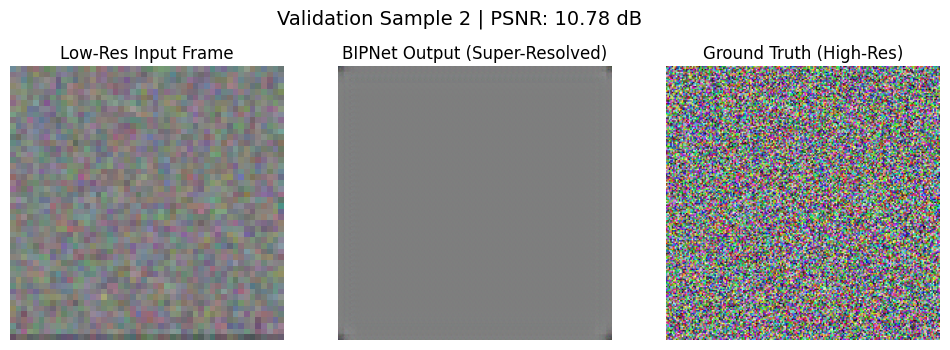

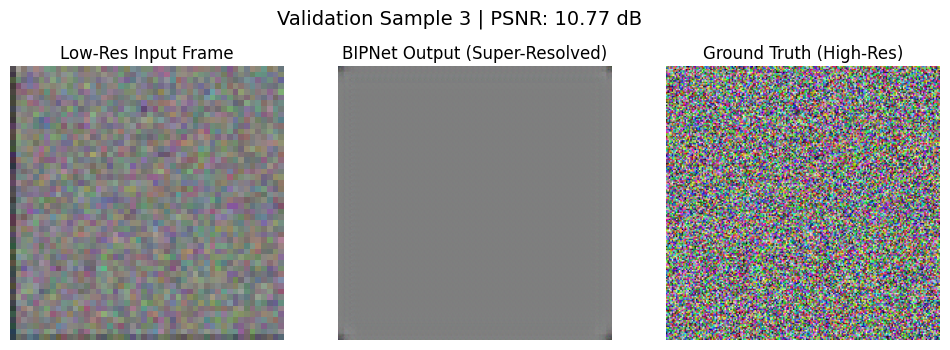

In [ ]:
# ==================== Step 8: Visualization & Evaluation ====================
# ----------------------------------------------------------
# Inference on few validation samples
# ----------------------------------------------------------
model.eval()
num_samples_to_show = 3

for i in range(num_samples_to_show):
    batch = val_dataset[i]
    burst = batch["burst"].unsqueeze(0).to(device)  # [1, N, 3, H, W]
    gt = batch["gt"].to(device)

    with torch.no_grad():
        output = model(burst)[0]  # [3, HR_H, HR_W]

    # clamp and convert to numpy
    output_np = torch.clamp(output, 0, 1).cpu().permute(1, 2, 0).numpy()
    gt_np = torch.clamp(gt, 0, 1).cpu().permute(1, 2, 0).numpy()
    lr_np = torch.clamp(burst[0, 0], 0, 1).cpu().permute(1, 2, 0).numpy()  # first LR frame

    # compute PSNR
    psnr_val = calculate_psnr(torch.tensor(output_np).permute(2,0,1), torch.tensor(gt_np).permute(2,0,1))
    
    # visualize
    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Validation Sample {i+1} | PSNR: {psnr_val:.2f} dB", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(lr_np)
    plt.title("Low-Res Input Frame")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(output_np)
    plt.title("BIPNet Output (Super-Resolved)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(gt_np)
    plt.title("Ground Truth (High-Res)")
    plt.axis('off')

    plt.show()


In [25]:
output_np = np.clip(output_np ** (1/2.2), 0, 1)


In [26]:
# ==================== Step 1: CIFAR10-based SyntheticBurst Generator ====================

import os
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageFilter
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from pathlib import Path
from PIL import Image
import glob


In [27]:

# ----------------------------------------------------------
# Download CIFAR-10 dataset (real natural images)
# ----------------------------------------------------------
base_data = CIFAR10(root='/kaggle/working/data', train=True, download=True,
                    transform=T.ToTensor())

def create_cifar_synthetic_burst(output_root, split='train', num_sequences=200,
                                 burst_size=8, image_size=48):
    """
    Creates SyntheticBurst-like dataset using real CIFAR-10 images.
    Each seq = 1 high-res image (gt.png) + burst of LR frames (frame_000...png)
    """
    os.makedirs(os.path.join(output_root, split), exist_ok=True)

    for i in tqdm(range(num_sequences), desc=f"Creating {split} dataset"):
        seq_dir = os.path.join(output_root, split, f"seq_{i:06d}")
        os.makedirs(seq_dir, exist_ok=True)

        # pick a CIFAR10 image
        img, _ = base_data[i % len(base_data)]
        gt_img = T.Resize(image_size * 4, interpolation=T.InterpolationMode.BICUBIC)(img)
        gt_img = T.ToPILImage()(gt_img)
        gt_img.save(os.path.join(seq_dir, "gt.png"))

        # generate LR burst images (small shift, blur, noise)
        for b in range(burst_size):
            frame = gt_img.copy()
            dx, dy = np.random.randint(-2, 3), np.random.randint(-2, 3)
            frame = frame.transform(frame.size, Image.AFFINE, (1, 0, dx, 0, 1, dy))
            frame = frame.filter(ImageFilter.GaussianBlur(radius=np.random.uniform(0, 1.0)))

            arr = np.array(frame).astype(np.float32)
            noise = np.random.normal(0, 5, arr.shape)
            noisy = np.clip(arr + noise, 0, 255).astype(np.uint8)
            noisy_img = Image.fromarray(noisy).resize((image_size, image_size), Image.BICUBIC)
            noisy_img.save(os.path.join(seq_dir, f"frame_{b:03d}.png"))

    print(f"✅ Done! Created {num_sequences} sequences for {split} split.")

# ----------------------------------------------------------
# Create dataset
# ----------------------------------------------------------
output_root = "/kaggle/working/datasets/synthetic_burst_cifar10"

create_cifar_synthetic_burst(output_root, split='train', num_sequences=400, burst_size=8, image_size=48)
create_cifar_synthetic_burst(output_root, split='val', num_sequences=100, burst_size=8, image_size=48)


100%|██████████| 170M/170M [00:02<00:00, 73.4MB/s] 
Creating train dataset: 100%|██████████| 400/400 [00:26<00:00, 14.91it/s]


✅ Done! Created 400 sequences for train split.


Creating val dataset: 100%|██████████| 100/100 [00:06<00:00, 14.60it/s]

✅ Done! Created 100 sequences for val split.


In [28]:
# ==================== Step 2: Dataset Loader ====================



class SyntheticBurstDataset(Dataset):
    def __init__(self, root, split='train', burst_size=8, transform=None):
        self.root = Path(root)
        self.split = split
        self.burst_size = burst_size
        self.transform = transform or transforms.ToTensor()
        self.split_dir = self.root / split
        self.samples = sorted([p for p in self.split_dir.iterdir() if p.is_dir()])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq = self.samples[idx]
        frame_paths = sorted(glob.glob(str(seq / "frame_*.png")))[:self.burst_size]
        burst_imgs = [Image.open(fp).convert("RGB") for fp in frame_paths]
        gt_img = Image.open(seq / "gt.png").convert("RGB")

        burst_tensors = [self.transform(img) for img in burst_imgs]
        gt_tensor = self.transform(gt_img)
        burst_stack = torch.stack(burst_tensors, dim=0)  # [B,3,H,W]
        return {"burst": burst_stack, "gt": gt_tensor, "seq_name": seq.name}

# Create train/val datasets
dataset_root = "/kaggle/working/datasets/synthetic_burst_cifar10"
train_dataset = SyntheticBurstDataset(dataset_root, split="train", burst_size=8)
val_dataset   = SyntheticBurstDataset(dataset_root, split="val", burst_size=8)

print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)


Training samples: 400
Validation samples: 100


✅ Loaded best model: best_model_epoch9.pth


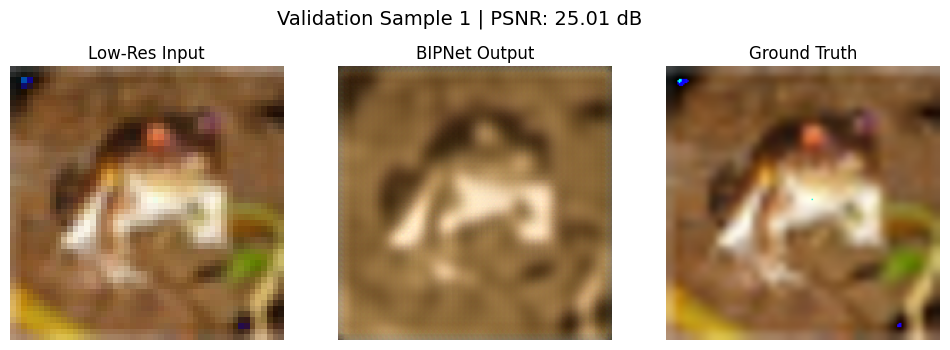

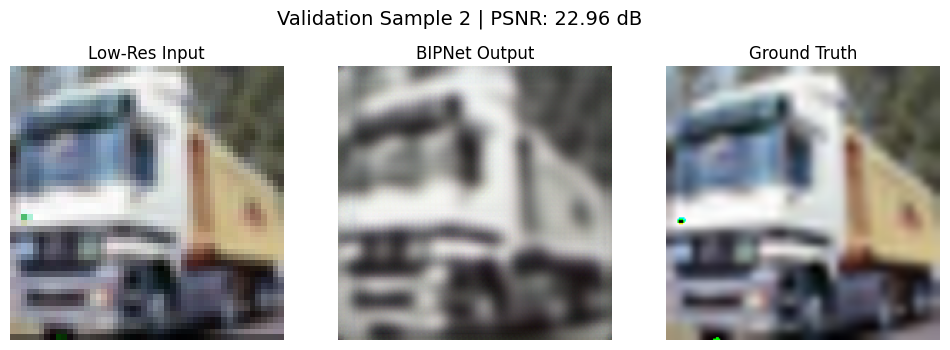

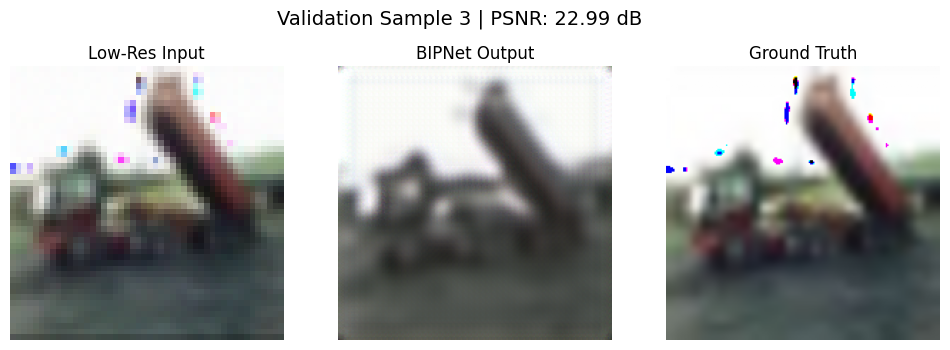

In [31]:
# ==================== Step 3: Visualization ====================

import matplotlib.pyplot as plt
import numpy as np
import torch

# Load the best checkpoint
best_model = sorted(os.listdir("/kaggle/working/bipnet_checkpoints"))[-1]
model.load_state_dict(torch.load(f"/kaggle/working/bipnet_checkpoints/{best_model}", map_location=device))
model.eval()

print(f"✅ Loaded best model: {best_model}")

num_samples_to_show = 3
for i in range(num_samples_to_show):
    batch = val_dataset[i]
    burst = batch["burst"].unsqueeze(0).to(device)
    gt = batch["gt"].to(device)

    with torch.no_grad():
        output = model(burst)[0]

    output_np = torch.clamp(output, 0, 1).cpu().permute(1, 2, 0).numpy()
    gt_np = torch.clamp(gt, 0, 1).cpu().permute(1, 2, 0).numpy()
    lr_np = torch.clamp(burst[0, 0], 0, 1).cpu().permute(1, 2, 0).numpy()

    psnr_val = calculate_psnr(torch.tensor(output_np).permute(2,0,1), torch.tensor(gt_np).permute(2,0,1))

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Validation Sample {i+1} | PSNR: {psnr_val:.2f} dB", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(lr_np)
    plt.title("Low-Res Input")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(output_np)
    plt.title("BIPNet Output")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(gt_np)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.show()
